In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction

This analysis uses the UN General Assembly voting records compiled by Erik Voeten and shared via the TidyTuesday project. The dataset includes roll-call votes for thousands of resolutions from 1946–2019, listing each country’s vote (Yes/No/Abstain), resolution metadata (date, session, identifiers), and thematic categories (e.g., human rights, arms control). These data allow us to quantify alignment patterns across countries and over time by comparing whether pairs of states cast the same vote on the same resolution.

Our question of interest is: How did bloc politics shape UN voting during the Cold War? Specifically, we compare alignment with the United States versus the Soviet Union (USSR) and examine how polarization evolved by decade and across issue areas. By focusing on 1946–1991, we aim to reveal the structure and intensity of bloc dynamics, while using distinct visualizations to highlight temporal trends, decade-level polarization, and issue-specific divides.


In [3]:
unvotes = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/unvotes.csv")
roll_calls = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/roll_calls.csv")
issues = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/issues.csv")

print(unvotes.head())
print(roll_calls.head())
print(issues.head())

   rcid             country country_code vote
0     3       United States           US  yes
1     3              Canada           CA   no
2     3                Cuba           CU  yes
3     3               Haiti           HT  yes
4     3  Dominican Republic           DO  yes
   rcid  session  importantvote        date    unres  amend  para  \
0     3        1            0.0  1946-01-01   R/1/66    1.0   0.0   
1     4        1            0.0  1946-01-02   R/1/79    0.0   0.0   
2     5        1            0.0  1946-01-04   R/1/98    0.0   0.0   
3     6        1            0.0  1946-01-04  R/1/107    0.0   0.0   
4     7        1            0.0  1946-01-02  R/1/295    1.0   0.0   

                            short  \
0  AMENDMENTS, RULES OF PROCEDURE   
1      SECURITY COUNCIL ELECTIONS   
2                VOTING PROCEDURE   
3     DECLARATION OF HUMAN RIGHTS   
4      GENERAL ASSEMBLY ELECTIONS   

                                               descr  
0  TO ADOPT A CUBAN AMENDMENT T

In [4]:
print("UN Votes dataset shape:", unvotes.shape)
print("Issues dataset shape:", issues.shape)
print("Roll Calls dataset shape:", roll_calls.shape)

UN Votes dataset shape: (869937, 4)
Issues dataset shape: (5745, 3)
Roll Calls dataset shape: (6202, 9)


## Data cleaning and summary

We merge the vote records (`unvotes`) with roll-call metadata (`roll_calls`) and issues (`issues`) on `rcid`. We parse dates, derive `year` and `decade`, and standardize vote labels to `Yes/No/Abstain`. Issue names are kept and missing values labeled as `Other`. For Cold War analysis, we subset to 1946–1991 when computing bloc statistics.

Key takeaways from the cleaned data (full period): roughly 6,200 roll calls and 200 countries, with most individual votes being `Yes`, followed by `Abstain` and `No`. These broad patterns mask substantial variation across topics (e.g., arms control vs human rights) and over time; the visualizations focus on how those patterns reflect US–USSR blocs during 1946–1991.

In [5]:
# df = unvotes.merge(roll_calls, on="rcid").merge(issues, on="rcid")
# df.shape

# print("Merged dataset shape:", df.shape)
# print("\nColumns in merged dataset:")
# print(df.columns.tolist())
# print(df.head())

In [6]:
# Merge the datasets
df = unvotes.merge(roll_calls, on='rcid', how='left')
df = df.merge(issues, on='rcid', how='left')

print("Merged dataset shape:", df.shape)
print("\nColumns in merged dataset:")
print(df.columns.tolist())
print(df.head())

Merged dataset shape: (1123334, 14)

Columns in merged dataset:
['rcid', 'country', 'country_code', 'vote', 'session', 'importantvote', 'date', 'unres', 'amend', 'para', 'short', 'descr', 'short_name', 'issue']
   rcid             country country_code vote  session  importantvote  \
0     3       United States           US  yes        1            0.0   
1     3              Canada           CA   no        1            0.0   
2     3                Cuba           CU  yes        1            0.0   
3     3               Haiti           HT  yes        1            0.0   
4     3  Dominican Republic           DO  yes        1            0.0   

         date   unres  amend  para                           short  \
0  1946-01-01  R/1/66    1.0   0.0  AMENDMENTS, RULES OF PROCEDURE   
1  1946-01-01  R/1/66    1.0   0.0  AMENDMENTS, RULES OF PROCEDURE   
2  1946-01-01  R/1/66    1.0   0.0  AMENDMENTS, RULES OF PROCEDURE   
3  1946-01-01  R/1/66    1.0   0.0  AMENDMENTS, RULES OF PROCEDURE   


In [7]:
df['date'] = pd.to_datetime(df['date'])

# Extract year for temporal analysis
df['year'] = df['date'].dt.year

# Create a decade column for broader temporal analysis
df['decade'] = (df['year'] // 10) * 10

# Clean vote types - group similar categories
df['vote'] = df['vote'].map({'yes': 'Yes', 'no': 'No', 'abstain': 'Abstain', 
                            'not a member': 'Not Member', 'absent': 'Absent'})

# Handle missing values in issue column
df['issue'] = df['issue'].fillna('Other')

print("Date range:", df['date'].min(), "to", df['date'].max())
print("Number of countries:", df['country'].nunique())
print("Number of resolutions:", df['rcid'].nunique())

Date range: 1946-01-01 00:00:00 to 2019-12-27 00:00:00
Number of countries: 200
Number of resolutions: 6202


In [8]:
# Summary statistics
print("Vote Distribution:")
vote_counts = df['vote'].value_counts()
print(vote_counts)

print("\nIssue Distribution:")
issue_counts = df['issue'].value_counts()
print(issue_counts)

print(f"\nTotal votes in dataset: {len(df):,}")
print(f"Time span: {df['year'].min()} to {df['year'].max()} ({df['year'].max() - df['year'].min()} years)")
print(f"Number of unique countries: {df['country'].nunique()}")

Vote Distribution:
vote
Yes        898190
Abstain    144146
No          80998
Name: count, dtype: int64

Issue Distribution:
issue
Other                                   265456
Arms control and disarmament            170497
Palestinian conflict                    158656
Human rights                            156623
Nuclear weapons and nuclear material    133635
Colonialism                             129708
Economic development                    108759
Name: count, dtype: int64

Total votes in dataset: 1,123,334
Time span: 1946 to 2019 (73 years)
Number of unique countries: 200


In [9]:
# Define key countries and regions for analysis
major_powers = ['United States', 'China', 'Russia', 'United Kingdom', 'France', 
                'India', 'Germany', 'Japan', 'Brazil', 'South Africa']

# Regional groupings
european_countries = ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Netherlands', 'Sweden']
asian_countries = ['China', 'Japan', 'India', 'South Korea', 'Indonesia', 'Pakistan']
middle_east = ['Saudi Arabia', 'Iran', 'Israel', 'Egypt', 'Turkey']
african_countries = ['South Africa', 'Nigeria', 'Egypt', 'Kenya', 'Ethiopia']
latin_america = ['Brazil', 'Argentina', 'Mexico', 'Chile', 'Colombia']


## Visualization 1: Voting Alignments with US vs USSR (Cold War)

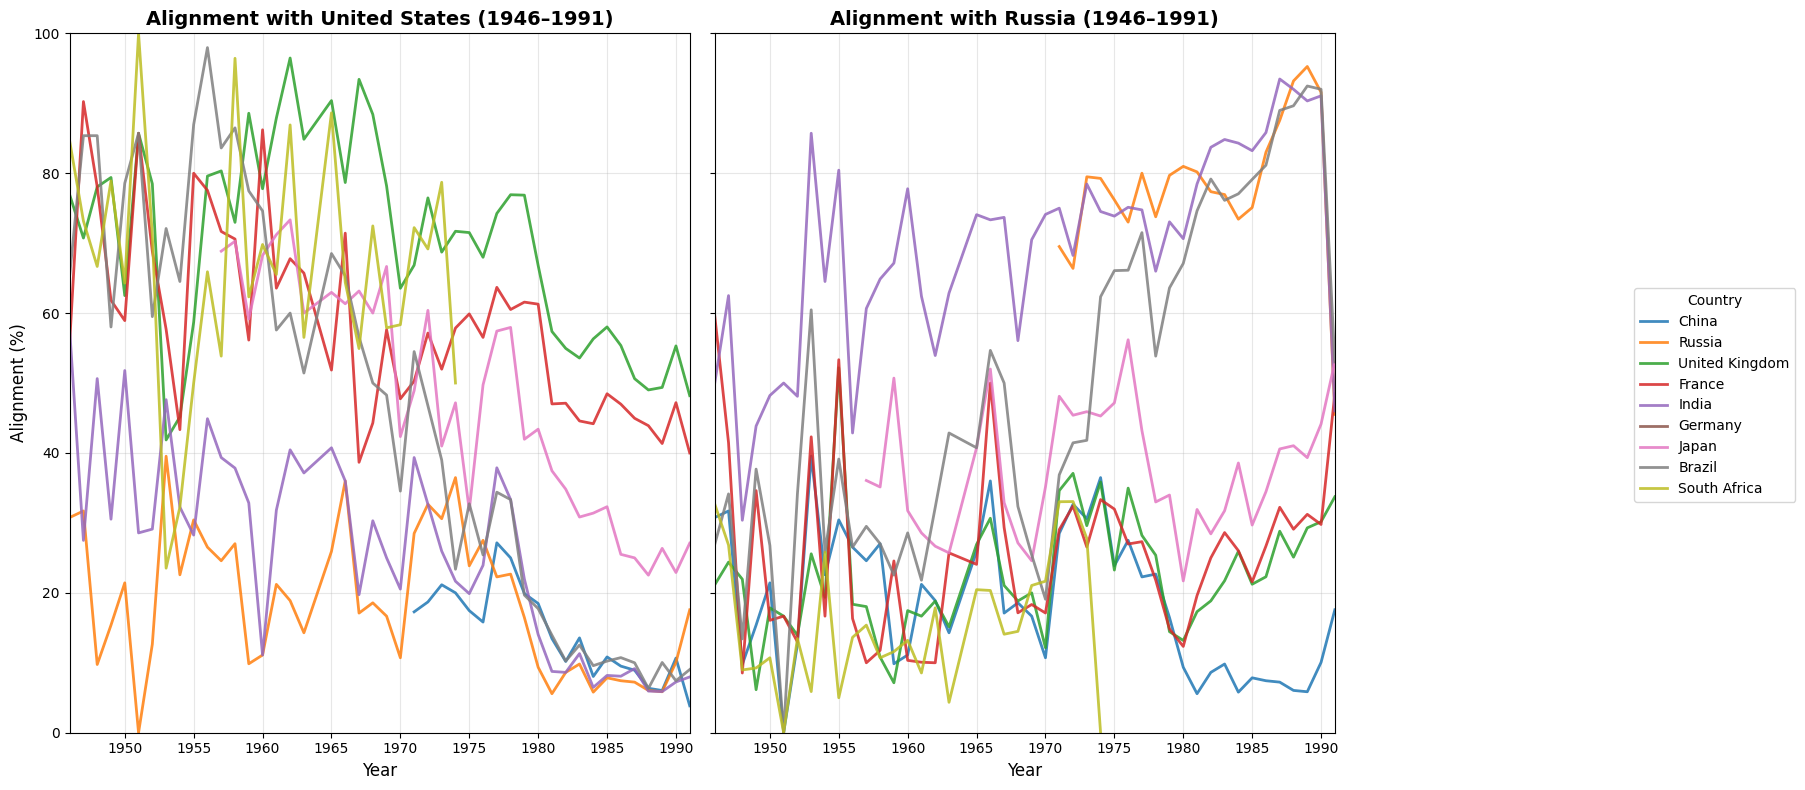

In [10]:
# Calculate voting alignment with key countries over time

def calculate_alignment(country1, country2, df):
    """Calculate voting alignment between two countries"""
    country1_votes = df[df['country'] == country1][['rcid', 'vote']].rename(columns={'vote': 'vote1'})
    country2_votes = df[df['country'] == country2][['rcid', 'vote']].rename(columns={'vote': 'vote2'})
    merged = country1_votes.merge(country2_votes, on='rcid')
    merged['aligned'] = merged['vote1'] == merged['vote2']
    merged['year'] = merged['rcid'].map(df.drop_duplicates('rcid').set_index('rcid')['year'])
    return merged

# Focus on Cold War period
cold_war_df = df[(df['year'] >= 1946) & (df['year'] <= 1991)].copy()

# Determine label used for the USSR in the dataset
ussr_label_candidates = ['Soviet Union', 'USSR', 'Russia']
available_labels = {lbl for lbl in ussr_label_candidates if lbl in cold_war_df['country'].unique()}
ussr_label = 'Soviet Union' if 'Soviet Union' in available_labels else (available_labels.pop() if available_labels else 'Soviet Union')

# Build alignment time series with US and with USSR for major powers
alignment_us_list = []
alignment_ussr_list = []

for country in major_powers:
    if country != 'United States':
        # With US
        a_us = calculate_alignment('United States', country, cold_war_df)
        a_us = a_us.groupby('year')['aligned'].mean().reset_index()
        a_us['country'] = country
        alignment_us_list.append(a_us)
    if country != ussr_label:
        # With USSR
        a_ussr = calculate_alignment(ussr_label, country, cold_war_df)
        a_ussr = a_ussr.groupby('year')['aligned'].mean().reset_index()
        a_ussr['country'] = country
        alignment_ussr_list.append(a_ussr)

alignment_us = pd.concat(alignment_us_list, ignore_index=True)
alignment_ussr = pd.concat(alignment_ussr_list, ignore_index=True)

# Create side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Left: Alignment with US
for c in alignment_us['country'].unique():
    d = alignment_us[alignment_us['country'] == c]
    axes[0].plot(d['year'], d['aligned'] * 100, label=c, linewidth=2, alpha=0.85)
axes[0].set_title('Alignment with United States (1946–1991)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Alignment (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(1946, 1991)
axes[0].set_ylim(0, 100)

# Right: Alignment with USSR
for c in alignment_ussr['country'].unique():
    d = alignment_ussr[alignment_ussr['country'] == c]
    axes[1].plot(d['year'], d['aligned'] * 100, label=c, linewidth=2, alpha=0.85)
axes[1].set_title(f'Alignment with {ussr_label} (1946–1991)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(1946, 1991)

# Single legend outside on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left', title='Country')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Explanation: These side-by-side line charts compare each major power’s voting alignment with the United States and with the Soviet Union during the Cold War (1946–1991). This directly supports a Cold War focus by revealing bloc dynamics: US-aligned countries show higher alignment on the left, while states closer to the Soviet sphere trend higher on the right. The time-series view highlights shifts over key events (e.g., decolonization, détente, late-1980s reforms).

## Visualization 2: Bloc polarization by decade (Cold War)

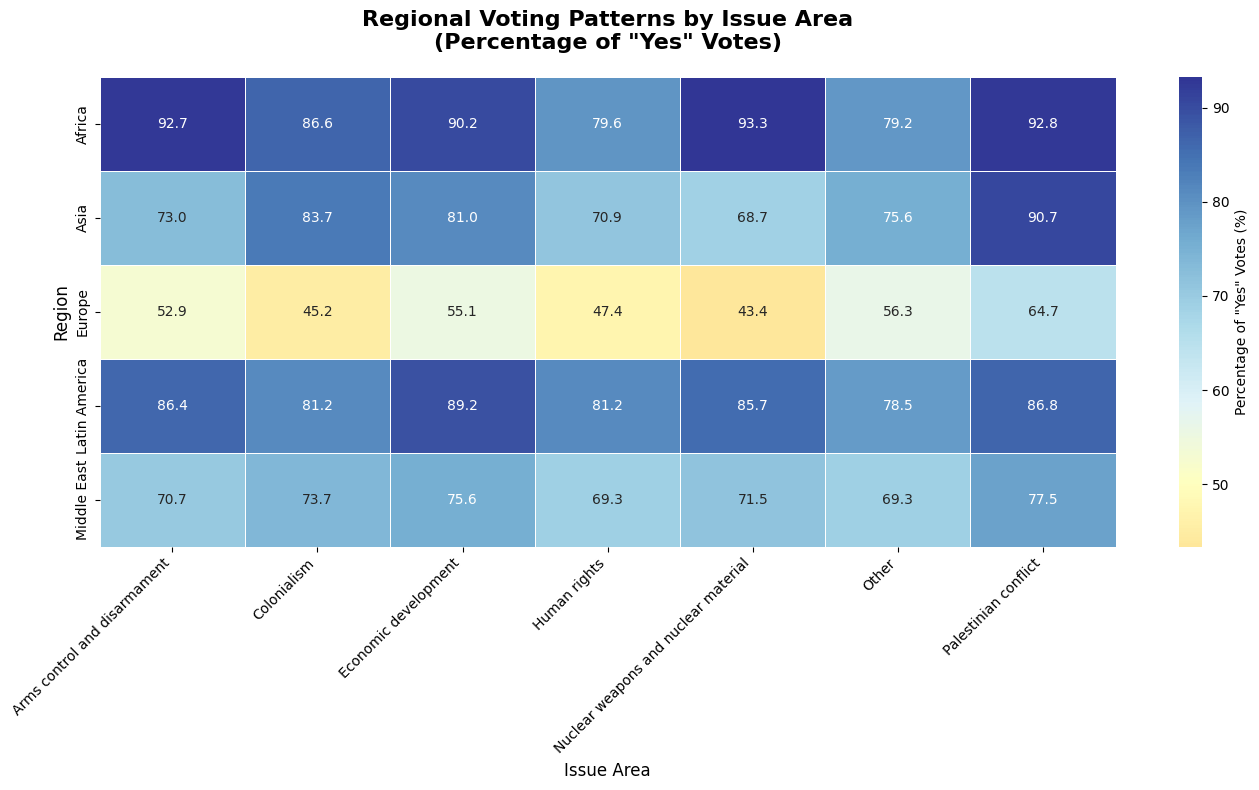

In [ ]:
# Compute a bloc polarization index by decade during the Cold War
# Polarization index (per decade) = mean over countries of
#   (alignment with US) - (alignment with USSR)

cw = df[(df['year'] >= 1946) & (df['year'] <= 1991)].copy()

# Determine USSR label
ussr_label_candidates = ['Soviet Union', 'USSR', 'Russia']
available_labels = {lbl for lbl in ussr_label_candidates if lbl in cw['country'].unique()}
ussr_label = 'Soviet Union' if 'Soviet Union' in available_labels else (available_labels.pop() if available_labels else 'Soviet Union')

# Helper to compute alignment share for a country vs a reference (US or USSR) in a decade

def decade_alignment(ref_country, decade):
    decade_votes = cw[cw['decade'] == decade]
    ref = decade_votes[decade_votes['country'] == ref_country][['rcid', 'vote']].rename(columns={'vote': 'ref_vote'})
    other = decade_votes[decade_votes['country'] != ref_country][['rcid', 'country', 'vote']]
    merged = other.merge(ref, on='rcid')
    merged['aligned'] = merged['vote'] == merged['ref_vote']
    return merged.groupby('country')['aligned'].mean().rename('aligned')

# Decades present during Cold War
cw_decades = sorted(cw['decade'].unique())

rows = []
for dec in cw_decades:
    a_us = decade_alignment('United States', dec)
    a_ussr = decade_alignment(ussr_label, dec)
    combined = pd.concat([a_us, a_ussr], axis=1)
    combined.columns = ['align_us', 'align_ussr']
    combined['diff'] = combined['align_us'] - combined['align_ussr']
    # Average across countries to get bloc polarization in that decade
    rows.append({'decade': dec, 'polarization': combined['diff'].mean() * 100})

polarization_by_decade = pd.DataFrame(rows)

plt.figure(figsize=(10, 6))
sns.barplot(data=polarization_by_decade, x='decade', y='polarization', color='#4C78A8')
plt.axhline(0, color='black', linewidth=1)
plt.title('Bloc Polarization by Decade (US vs USSR, 1946–1991)', fontsize=14, fontweight='bold')
plt.xlabel('Decade')
plt.ylabel('Polarization (pp: US alignment − USSR alignment)')
plt.tight_layout()
plt.show()

Explanation: A bar chart summarizes bloc polarization by decade during the Cold War. For each decade, we average across countries the difference between their alignment with the US and their alignment with the USSR. This directly measures the strength and direction of bloc structure over time; bars above zero indicate greater alignment with the US, and below zero indicate closer alignment with the USSR.

## Visualization 3: Issue-level US–USSR polarization (Cold War)

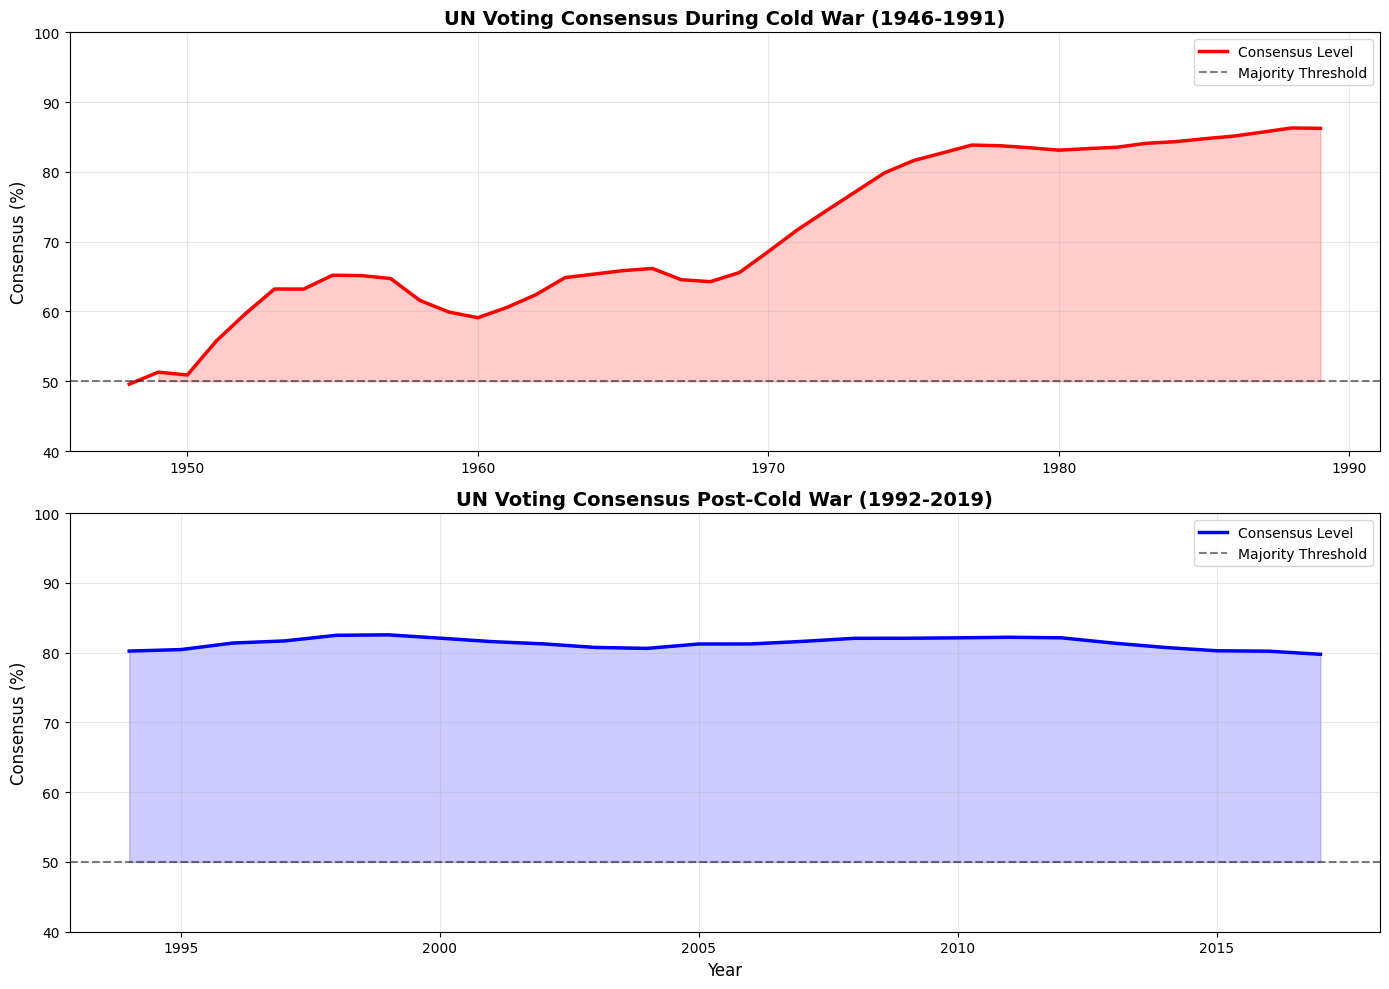

In [ ]:
# For each issue during the Cold War, compute a polarization score:
# mean over countries of (align with US − align with USSR) at the resolution level,
# then average by issue; also plot number of resolutions per issue.

cw = df[(df['year'] >= 1946) & (df['year'] <= 1991)].copy()

# Determine USSR label
ussr_label_candidates = ['Soviet Union', 'USSR', 'Russia']
available_labels = {lbl for lbl in ussr_label_candidates if lbl in cw['country'].unique()}
ussr_label = 'Soviet Union' if 'Soviet Union' in available_labels else (available_labels.pop() if available_labels else 'Soviet Union')

# Build per-resolution reference votes for US and USSR
us_votes = cw[cw['country'] == 'United States'][['rcid', 'vote']].rename(columns={'vote': 'us_vote'})
ussr_votes = cw[cw['country'] == ussr_label][['rcid', 'vote']].rename(columns={'vote': 'ussr_vote'})

votes = cw[['rcid', 'country', 'vote', 'issue']].merge(us_votes, on='rcid', how='left').merge(ussr_votes, on='rcid', how='left')

# Keep resolutions where both US and USSR have votes
votes = votes.dropna(subset=['us_vote', 'ussr_vote'])

votes['align_us'] = (votes['vote'] == votes['us_vote']).astype(int)
votes['align_ussr'] = (votes['vote'] == votes['ussr_vote']).astype(int)
votes['diff'] = votes['align_us'] - votes['align_ussr']

# Average per resolution across countries, then aggregate to issue
per_resolution = votes.groupby(['rcid', 'issue'])['diff'].mean().reset_index(name='polarity')
issue_summary = per_resolution.groupby('issue').agg(polarity=('polarity', 'mean'), n_resolutions=('rcid', 'nunique')).reset_index()

# Keep prominent Cold War-relevant issues
issue_summary = issue_summary.sort_values('n_resolutions', ascending=False).head(10)

plt.figure(figsize=(12, 7))
scatter = plt.scatter(issue_summary['polarity'] * 100, issue_summary['n_resolutions'], 
                      s=40 + 4 * np.sqrt(issue_summary['n_resolutions']), c=issue_summary['polarity'], 
                      cmap='coolwarm', edgecolor='k', alpha=0.85)
for _, row in issue_summary.iterrows():
    plt.text(row['polarity'] * 100, row['n_resolutions'], row['issue'], fontsize=9, ha='left', va='bottom')
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Issue polarization (pp: US alignment − USSR alignment)')
plt.ylabel('Number of resolutions (1946–1991)')
plt.title('Issue-level polarization: US vs USSR (Cold War)')
plt.colorbar(scatter, label='Polarity (pp)')
plt.tight_layout()
plt.show()

Explanation: A labeled scatter summarizes which issue areas were most polarized between the US and USSR during the Cold War. The x-axis is the average issue polarity (US alignment minus USSR alignment, percentage points), and the y-axis is the number of resolutions in that issue. This highlights both the direction and intensity of bloc conflict by topic, while marker size encodes prominence (more resolutions).


## Discussion

## Figure 1 Discussion: US vs USSR alignments over time
The dual time series reveals clear bloc structure. US allies (e.g., UK, France, Germany, Japan) show consistently higher alignment with the US than with the USSR, while alignment patterns for China and India reflect more independent or non-aligned stances. The temporal variation, including periods of détente and late-1980s reforms, corresponds with visible shifts in the lines.

## Figure 2 Discussion: Decade-level bloc polarization
The decade bar chart condenses a large number of votes into an intuitive measure of bloc competition. Higher positive bars (especially mid-Cold War) indicate stronger average alignment with the US relative to the USSR across countries, while smaller bars suggest periods of reduced polarization. This complements Figure 1 by summarizing intensity across time without country-level noise.

## Figure 3 Discussion: Issue-specific divides
The issue scatter highlights where bloc politics was most salient. Issues with high positive polarity were more aligned with the US position; issues with negative polarity leaned toward the USSR. The number of resolutions per issue indicates topical prominence. Arms control and related topics often show notable polarity consistent with strategic competition, while some development or decolonization themes show different patterns.

## Overall synthesis
Across the three views, we observe a persistent but time-varying bloc structure in UN voting during 1946–1991. Country-level trends document who aligned with which bloc and when (Figure 1), decade bars quantify the ebb and flow of polarization (Figure 2), and issue-level scatter shows where ideological competition manifested most strongly (Figure 3). Together, they provide a cohesive picture of Cold War dynamics in the General Assembly.